In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
import matplotlib.dates as mdates 

##reading genration dataset
custom_date_parser = lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M') 
gen=pd.read_csv('Plant_1_Generation_Data.csv',index_col='DATE_TIME', parse_dates=['DATE_TIME'], date_parser=custom_date_parser)
gen.head(2)

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0


In [2]:
train=gen['2020-06-13 00:00:00':'2020-06-16 00:00:00'].drop('SOURCE_KEY',axis=1).groupby('DATE_TIME').sum()
test=gen['2020-06-16 00:00:00':'2020-06-16 23:45:00'].drop('SOURCE_KEY',axis=1).groupby('DATE_TIME').sum()

<Axes: xlabel='DATE_TIME', ylabel='DC_POWER'>

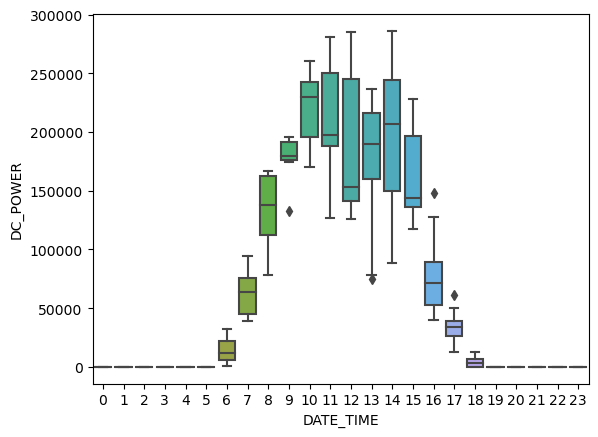

In [3]:
sns.boxplot(x=train.index.hour, y=train.DC_POWER)

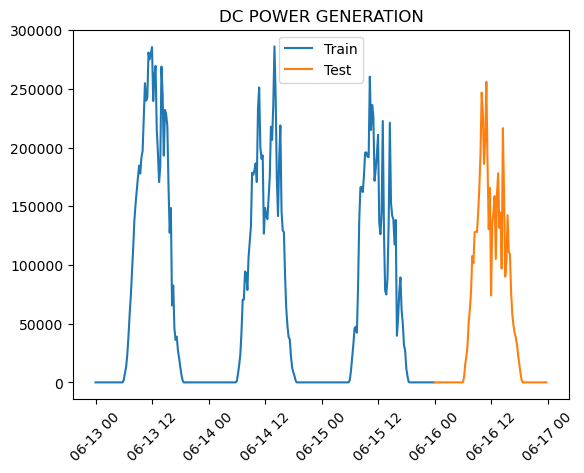

In [4]:
plt.plot(train.DC_POWER, label='Train')
plt.plot(test.DC_POWER,label='Test')
plt.xticks(rotation=45)
plt.title('DC POWER GENERATION')
plt.legend()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train.DC_POWER)
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"{key}: {value}")

ADF Statistic: -3.820570999279649
p-value: 0.002703721620386382
Critical Values:
1%: -3.45453261164607
5%: -2.8721859575020017
10%: -2.572442854861866


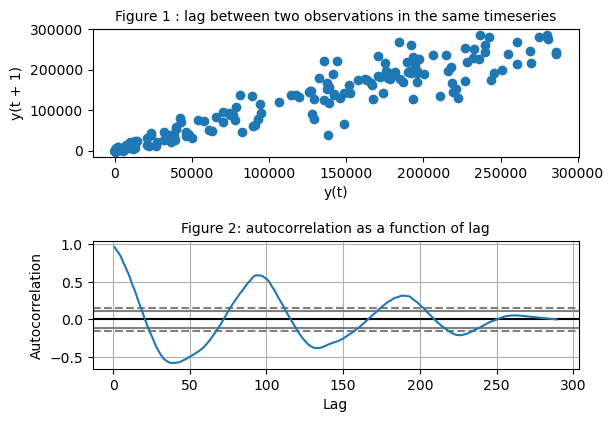

In [6]:
f,ax= plt.subplots(2,1)
plt.tight_layout(pad=4)
pd.plotting.lag_plot(train.DC_POWER, ax=ax[0])
pd.plotting.autocorrelation_plot(train.DC_POWER,ax=ax[1])
ax[0].set_title('Figure 1 : lag between two observations in the same timeseries', fontsize=10)
ax[1].set_title('Figure 2: autocorrelation as a function of lag',fontsize=10)

plt.show()

In [7]:
from prophet import Prophet
train_pr=gen['2020-06-13 00:00:00':'2020-06-16 00:00:00'].drop('SOURCE_KEY',axis=1).DC_POWER.groupby('DATE_TIME').sum().reset_index()
test_pr=gen['2020-06-16 00:00:00':'2020-06-16 23:45:00'].drop('SOURCE_KEY',axis=1).DC_POWER.groupby('DATE_TIME').sum()

train_pr.columns=['ds','y']
model=Prophet()
model.fit(train_pr)

13:34:50 - cmdstanpy - INFO - Chain [1] start processing
13:34:50 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
test_dates=pd.DataFrame(test_pr.index).rename(columns={'DATE_TIME':'ds'})
forecast_prophet=model.predict(test_dates)

dates=pd.date_range(start='2020-06-16 23:45:00',end='2020-06-17 23:45:00',freq=pd.DateOffset(minutes=15))
future_dates=pd.DataFrame(dates,columns=['ds'])
future_prophet=model.predict(future_dates)

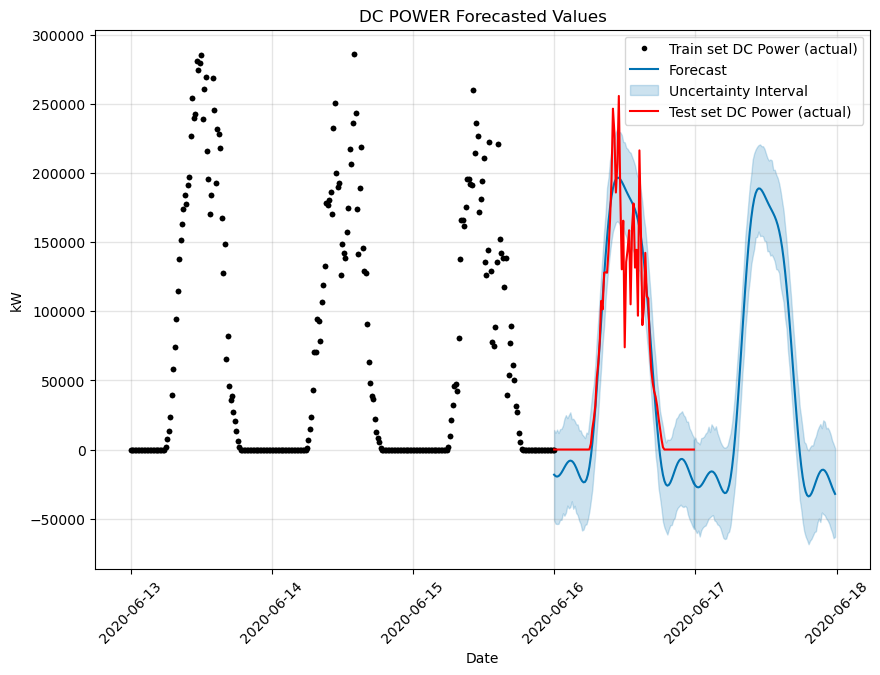

In [9]:
plt.figure(figsize=(10,7))
fig1=model.plot(forecast_prophet,ax=plt.gca())
fig1=model.plot(future_prophet,ax=plt.gca())
fig2=plt.plot(test_pr,'r-', label='Actual from test set')

handles1, labels1 = fig1.gca().get_legend_handles_labels()
handles=handles1[0:3]+fig2
labels1 =['Train set DC Power (actual)', 'Forecast', 'Uncertainty Interval','Test set DC Power (actual)']

fig1.gca().legend(handles, labels1,loc='upper right')
plt.xlabel('Date')
plt.ylabel('kW')
plt.title('DC POWER Forecasted Values')
plt.xticks(rotation=45)
plt.show()

In [10]:
from pandas.tseries.offsets import DateOffset
! pip install pmdarima
from pmdarima.arima import auto_arima

In [11]:
train_arima=gen['2020-06-13 00:00:00':'2020-06-16 00:00:00'].drop('SOURCE_KEY',axis=1).groupby('DATE_TIME').sum()
test_arima=gen['2020-06-16 00:00:00':'2020-06-16 23:45:00'].drop('SOURCE_KEY',axis=1).groupby('DATE_TIME').sum()

arima_model = auto_arima(train_arima.DC_POWER,
                         start_p=0,d=0,start_q=0,
                         max_p=2,max_d=0,max_q=2,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[96] intercept   : AIC=4623.848, Time=0.53 sec
 ARIMA(1,0,0)(1,1,0)[96] intercept   : AIC=4478.869, Time=8.77 sec
 ARIMA(0,0,1)(0,1,1)[96] intercept   : AIC=4498.071, Time=10.25 sec
 ARIMA(0,0,0)(0,1,0)[96]             : AIC=4641.102, Time=0.81 sec
 ARIMA(1,0,0)(0,1,0)[96] intercept   : AIC=4500.445, Time=0.69 sec
 ARIMA(1,0,0)(1,1,1)[96] intercept   : AIC=4476.612, Time=15.10 sec
 ARIMA(1,0,0)(0,1,1)[96] intercept   : AIC=4474.622, Time=12.27 sec
 ARIMA(0,0,0)(0,1,1)[96] intercept   : AIC=4589.492, Time=5.98 sec
 ARIMA(2,0,0)(0,1,1)[96] intercept   : AIC=4475.584, Time=19.73 sec
 ARIMA(1,0,1)(0,1,1)[96] intercept   : AIC=4472.357, Time=22.58 sec
 ARIMA(1,0,1)(0,1,0)[96] intercept   : AIC=4496.749, Time=1.88 sec
 ARIMA(1,0,1)(1,1,1)[96] intercept   : AIC=4474.108, Time=20.16 sec
 ARIMA(1,0,1)(1,1,0)[96] intercept   : AIC=4476.690, Time=14.80 sec
 ARIMA(2,0,1)(0,1,1)[96] intercept   : AIC=inf, Time=32.74 sec
 ARIMA(1,0,2)(0,

In [12]:
dates=pd.date_range(start=test_arima.index[0],end='2020-06-17 23:45:00',freq=pd.DateOffset(minutes=15))

prediction_test=pd.DataFrame(arima_model.predict(n_periods=len(dates)),index=dates)
prediction_test.columns=['predicted_yield']
prediction_test.isnull().sum()

predicted_yield    1
dtype: int64

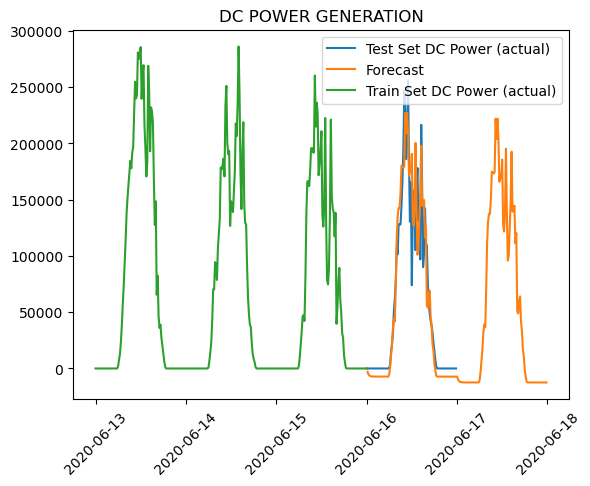

In [13]:
plt.plot(test_arima.DC_POWER,label='Test Set DC Power (actual)')
plt.plot(prediction_test, label='Forecast')
plt.plot(train_arima.DC_POWER, label='Train Set DC Power (actual)')
#plt.plot(prediction_future, label='Future Generation')
plt.xticks(rotation=45)
plt.title('DC POWER GENERATION')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
# proohet
y_prophet=forecast_prophet.set_index('ds').yhat 
test_pr=pd.DataFrame(test_pr) 

#Arima
y_arima=pd.DataFrame(arima_model.predict(n_periods=len(test_arima)),index=test_arima.index, columns=['Arima Forecast'])['Arima Forecast']
test_arima.DC_POWER
y_arima.fillna(0,inplace=True)

In [15]:
print('ARIMA R2 Score: %f' % (r2_score(y_arima, test_arima.DC_POWER)))
print('Prophet R2 Score: %f' % (r2_score(y_prophet,test_pr)))
print('-'*15)
print('ARIMA MAE Score: %f' % (mean_absolute_error(y_arima, test_arima.DC_POWER)))
print('Prophet MAE Score: %f' % (mean_absolute_error(y_prophet,test_pr)))
print('-'*15)
print('ARIMA RMSE Score: %f' % (mean_squared_error(y_arima, test_arima.DC_POWER,squared=False)))
print('Prophet RMSE Score: %f' % (mean_squared_error(y_prophet,test_pr,squared=False)))

ARIMA R2 Score: 0.894025
Prophet R2 Score: 0.897975
---------------
ARIMA MAE Score: 15882.183111
Prophet MAE Score: 20164.078884
---------------
ARIMA RMSE Score: 25400.796426
Prophet RMSE Score: 27030.253715
